In [38]:
#2
import sympy as sp

mu, sigma = sp.symbols('mu sigma')
n = 10
x = sp.symbols('x1:%d' % (n + 1))

log_verosimilitud = -n/2 * sp.log(2 * sp.pi * sigma**2) - 1/(2 * sigma**2) * sum((x[i] - mu)**2 for i in range(n))

dL_dmu = sp.diff(log_verosimilitud, mu)
dL_dsigma = sp.diff(log_verosimilitud, sigma)
d2L_dmu2 = sp.simplify(sp.diff(dL_dmu, mu))
d2L_dsigma2 = sp.simplify(sp.diff(dL_dsigma, sigma))


Hessiana = sp.Matrix([[d2L_dmu2, 0], [0, d2L_dsigma2]])

valor_mu = 0
valor_sigma = 1
Hessiana_evaluada = Hessiana.subs({mu: valor_mu, sigma: valor_sigma})

print("Matriz Hessiana evaluada:")
for row in Hessiana_evaluada.tolist():
    print([sp.N(elem) for elem in row])


Matriz Hessiana evaluada:
[-10.0000000000000, 0]
[0, -3.0*x1**2 - 3.0*x10**2 - 3.0*x2**2 - 3.0*x3**2 - 3.0*x4**2 - 3.0*x5**2 - 3.0*x6**2 - 3.0*x7**2 - 3.0*x8**2 - 3.0*x9**2 + 10.0]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Estimación de mu: 4.00977271826665
Estimación de sigma: 1.8406772574804735
Error en mu (68% CL): 0.1855684423286872
Error en sigma (68% CL): 0.13680045667994803


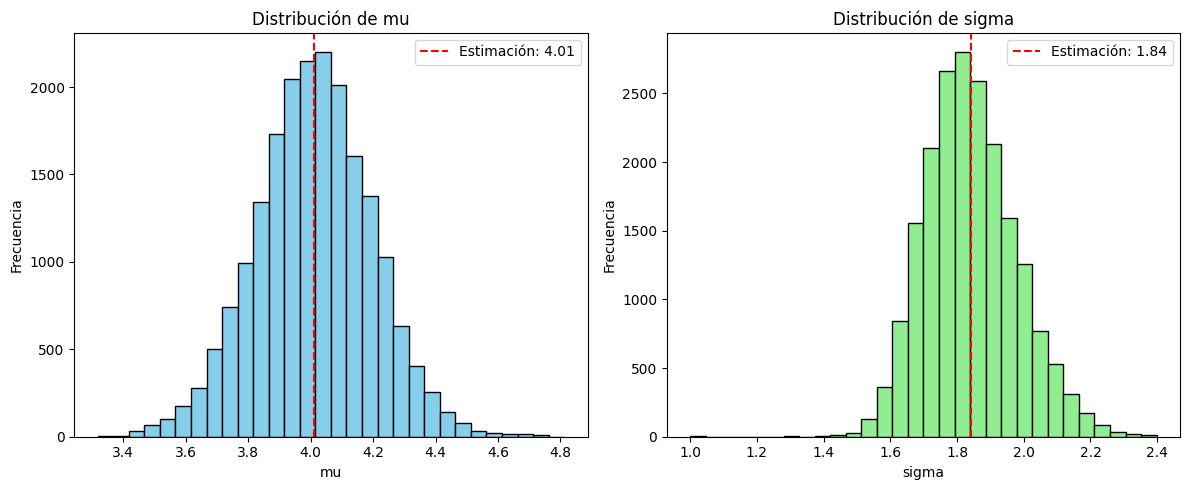

In [34]:
#3

import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

datos = np.loadtxt("/content/drive/My Drive/ColabData/GaussianData.txt", skiprows=1)

def log_priori(mu, sigma):
    if 3 <= mu <= 5 and 0.5 <= sigma <= 3.5:
        return 0
    else:
        return -1e6

def log_verosimilitud(datos, mu, sigma):
    N = len(datos)
    return -0.5 * N * np.log(2 * np.pi * sigma ** 2) - np.sum((datos - mu) ** 2) / (2 * sigma ** 2)

def log_posterior(datos, mu, sigma):
    return log_verosimilitud(datos, mu, sigma) + log_priori(mu, sigma)

def metropolis(datos, N=20000, mu_inicial=4, sigma_inicial=1):
    muestras_mu = np.zeros(N)
    muestras_sigma = np.zeros(N)
    muestras_mu[0], muestras_sigma[0] = mu_inicial, sigma_inicial

    for i in range(1, N):
        propuesta_mu = np.random.normal(muestras_mu[i-1], 0.1)
        propuesta_sigma = np.abs(np.random.normal(muestras_sigma[i-1], 0.1))

        log_posterior_actual = log_posterior(datos, muestras_mu[i-1], muestras_sigma[i-1])
        log_posterior_propuesta = log_posterior(datos, propuesta_mu, propuesta_sigma)

        alfa = np.exp(log_posterior_propuesta - log_posterior_actual)
        if np.random.rand() < alfa:
            muestras_mu[i], muestras_sigma[i] = propuesta_mu, propuesta_sigma
        else:
            muestras_mu[i], muestras_sigma[i] = muestras_mu[i-1], muestras_sigma[i-1]

    return muestras_mu, muestras_sigma

muestras_mu, muestras_sigma = metropolis(datos)

mu_est = np.mean(muestras_mu)
sigma_est = np.mean(muestras_sigma)

print("Estimación de mu:", mu_est)
print("Estimación de sigma:", sigma_est)

error_mu = np.std(muestras_mu)
error_sigma = np.std(muestras_sigma)

print("Error en mu (68% CL):", error_mu)
print("Error en sigma (68% CL):", error_sigma)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(muestras_mu, bins=30, color="skyblue", edgecolor="black")
plt.axvline(mu_est, color='red', linestyle='--', label=f'Estimación: {mu_est:.2f}')
plt.xlabel("mu")
plt.ylabel("Frecuencia")
plt.title("Distribución de mu")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(muestras_sigma, bins=30, color="lightgreen", edgecolor="black")
plt.axvline(sigma_est, color='red', linestyle='--', label=f'Estimación: {sigma_est:.2f}')
plt.xlabel("sigma")
plt.ylabel("Frecuencia")
plt.title("Distribución de sigma")
plt.legend()

plt.tight_layout()
plt.show()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Estimación de mu: 4.014376906803678
Estimación de sigma: 1.8367888181102376
Error en mu (68% CL): 0.18540183255584444
Error en sigma (68% CL): 0.13686815342934788


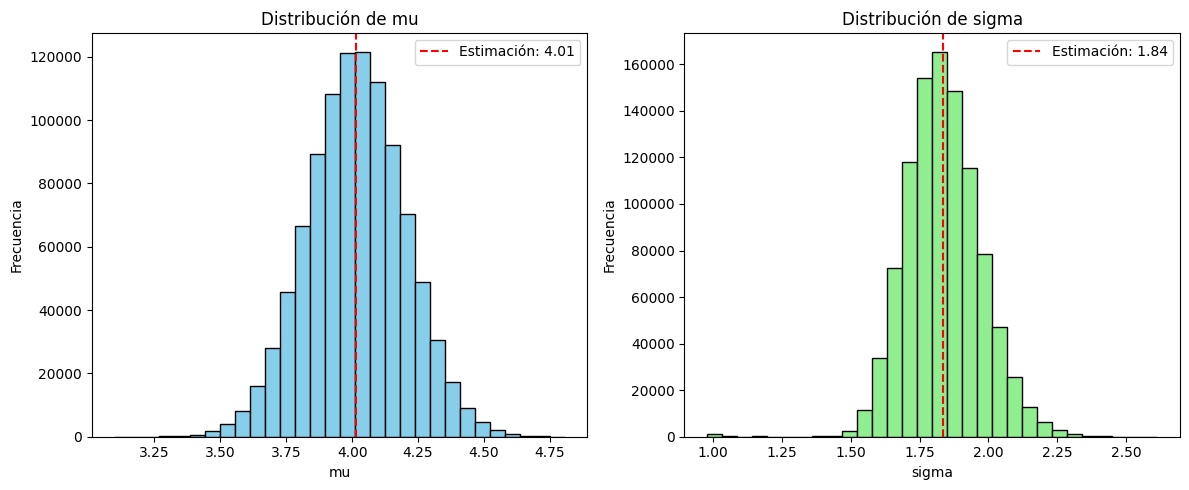

In [35]:
#4
!pip install emcee
import numpy as np
import matplotlib.pyplot as plt
import emcee
from google.colab import drive

drive.mount('/content/drive')

datos = np.loadtxt("/content/drive/My Drive/ColabData/GaussianData.txt", skiprows=1)

def log_priori(mu, sigma):
    if 3 <= mu <= 5 and 0.5 <= sigma <= 3.5:
        return 0
    else:
        return -1e6

def log_verosimilitud(datos, mu, sigma):
    N = len(datos)
    return -0.5 * N * np.log(2 * np.pi * sigma ** 2) - np.sum((datos - mu) ** 2) / (2 * sigma ** 2)

def log_posterior(params):
    mu, sigma = params
    return log_verosimilitud(datos, mu, sigma) + log_priori(mu, sigma)

initial = [4.0, 1.0]
nwalkers = 50
ndim = len(initial)
nsteps = 20000

pos = [initial + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

sampler.run_mcmc(pos, nsteps)

samples = sampler.get_chain(flat=True)

mu_est, sigma_est = np.mean(samples, axis=0)

print("Estimación de mu:", mu_est)
print("Estimación de sigma:", sigma_est)

error_mu = np.std(samples[:, 0])
error_sigma = np.std(samples[:, 1])

print("Error en mu (68% CL):", error_mu)
print("Error en sigma (68% CL):", error_sigma)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(samples[:, 0], bins=30, color="skyblue", edgecolor="black")
plt.axvline(mu_est, color='red', linestyle='--', label=f'Estimación: {mu_est:.2f}')
plt.xlabel("mu")
plt.ylabel("Frecuencia")
plt.title("Distribución de mu")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(samples[:, 1], bins=30, color="lightgreen", edgecolor="black")
plt.axvline(sigma_est, color='red', linestyle='--', label=f'Estimación: {sigma_est:.2f}')
plt.xlabel("sigma")
plt.ylabel("Frecuencia")
plt.title("Distribución de sigma")
plt.legend()

plt.tight_layout()
plt.show()


<ipython-input-36-cbc346627c11>:11: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  poisson_term = (np.exp(-(mu * s + epsilon * b)) * (mu * s + epsilon * b) ** n) / np.math.factorial(n)


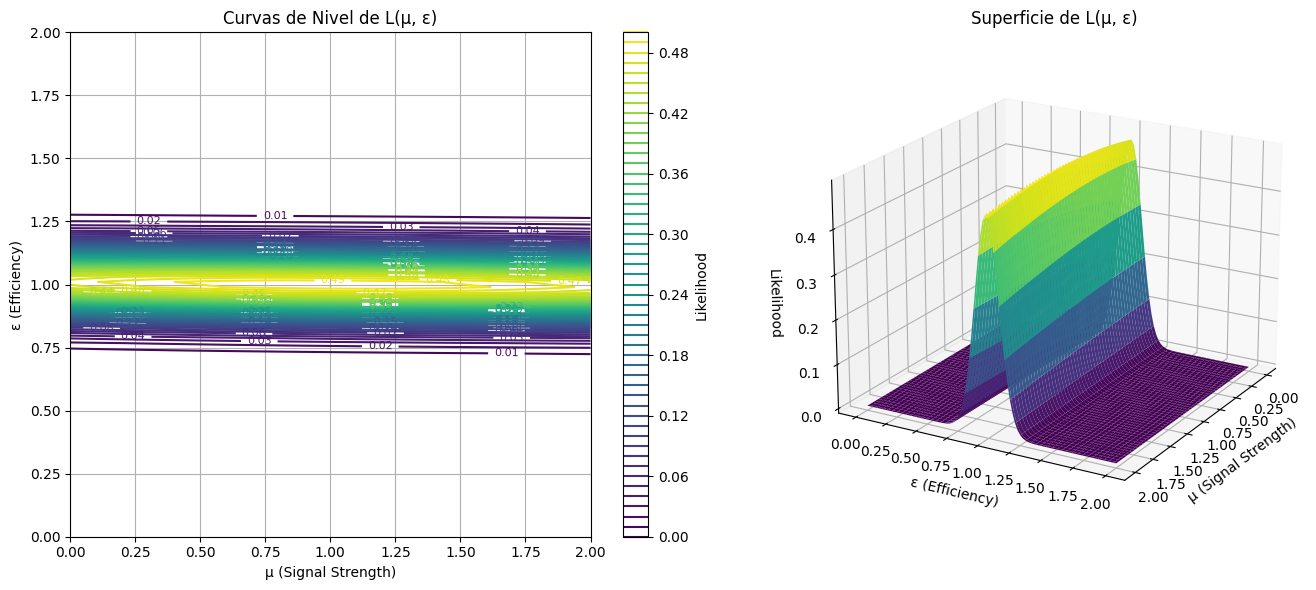

Estimación de μ: 1.15, Estimación de ε: 1.00
Estimación de μ sin error sistemático: 2.00


<ipython-input-36-cbc346627c11>:76: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  poisson_term = (np.exp(-(mu * s)) * (mu * s) ** n) / np.math.factorial(n)


In [36]:
#6
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

n = 10
b = 9
sigma = 0.1
s = 1

def likelihood(mu, epsilon):
    poisson_term = (np.exp(-(mu * s + epsilon * b)) * (mu * s + epsilon * b) ** n) / np.math.factorial(n)
    gaussian_term = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-((epsilon - 1) ** 2) / (2 * sigma ** 2))
    return poisson_term * gaussian_term

mu_values = np.linspace(0, 2, 100)
epsilon_values = np.linspace(0, 2, 100)
mu_grid, epsilon_grid = np.meshgrid(mu_values, epsilon_values)

L = likelihood(mu_grid, epsilon_grid)

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121)
contour = ax1.contour(mu_grid, epsilon_grid, L, levels=50, cmap='viridis')
ax1.clabel(contour, inline=True, fontsize=8)
ax1.set_xlabel('μ (Signal Strength)')
ax1.set_ylabel('ε (Efficiency)')
ax1.set_title('Curvas de Nivel de L(μ, ε)')
plt.colorbar(contour, ax=ax1, label='Likelihood')
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 2)
ax1.grid()

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(mu_grid, epsilon_grid, L, cmap='viridis', edgecolor='none')
ax2.set_xlabel('μ (Signal Strength)')
ax2.set_ylabel('ε (Efficiency)')
ax2.set_zlabel('Likelihood')
ax2.set_title('Superficie de L(μ, ε)')
ax2.view_init(elev=20, azim=30)

plt.tight_layout()
plt.show()

def metropolis_hastings(n_samples=10000):
    mu_current = 1.0
    epsilon_current = 1.0
    samples = []

    for _ in range(n_samples):
        mu_proposed = np.random.normal(mu_current, 0.1)
        epsilon_proposed = np.random.normal(epsilon_current, 0.1)

        if mu_proposed < 0 or mu_proposed > 2 or epsilon_proposed < 0 or epsilon_proposed > 2:
            continue

        L_current = likelihood(mu_current, epsilon_current)
        L_proposed = likelihood(mu_proposed, epsilon_proposed)

        r = L_proposed / L_current

        if np.random.rand() < r:
            mu_current = mu_proposed
            epsilon_current = epsilon_proposed

        samples.append((mu_current, epsilon_current))

    return np.array(samples)

samples = metropolis_hastings()
mu_estimate, epsilon_estimate = np.mean(samples, axis=0)

print(f"Estimación de μ: {mu_estimate:.2f}, Estimación de ε: {epsilon_estimate:.2f}")

def likelihood_without_gaussian(mu):
    poisson_term = (np.exp(-(mu * s)) * (mu * s) ** n) / np.math.factorial(n)
    return poisson_term

mu_values_no_gaussian = np.linspace(0, 2, 100)
L_no_gaussian = likelihood_without_gaussian(mu_values_no_gaussian)


mu_no_gaussian_estimate = mu_values_no_gaussian[np.argmax(L_no_gaussian)]

print(f"Estimación de μ sin error sistemático: {mu_no_gaussian_estimate:.2f}")




<ipython-input-37-17745b8aec7c>:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  poisson_term = (np.exp(-(mu * s + epsilon * b)) * (mu * s + epsilon * b) ** n) / np.math.factorial(n)


Estimación de μ: 0.56 ± 0.33
Estimación de ε: 0.99 ± 0.06
Conclusiones sobre la observación realizada:
Los datos sugieren que podría existir vida extraterrestre, pero no es concluyente.


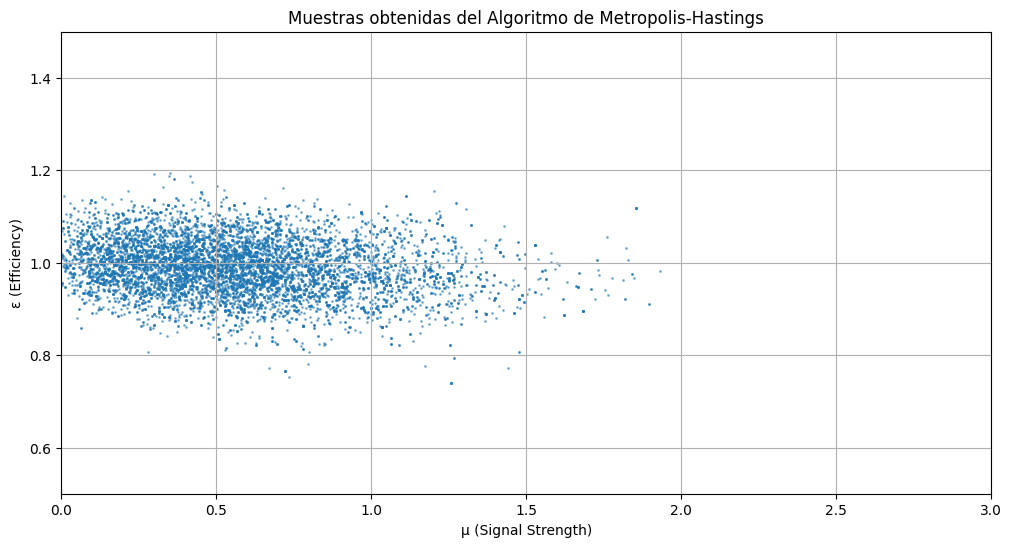

In [37]:
#7
import numpy as np
import matplotlib.pyplot as plt

Data = np.array([10, 20, 5])
bkg = np.array([6, 15, 10])
Signal = np.array([2, 10, 3])
sigma = 0.1

def likelihood_single(mu, epsilon, n, b, s):
    poisson_term = (np.exp(-(mu * s + epsilon * b)) * (mu * s + epsilon * b) ** n) / np.math.factorial(n)
    gaussian_term = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-((epsilon - 1) ** 2) / (2 * sigma ** 2))
    return poisson_term * gaussian_term

def likelihood_total(mu, epsilon):
    L = 1.0
    for i in range(len(Data)):
        L *= likelihood_single(mu, epsilon, Data[i], bkg[i], Signal[i])
    return L

def metropolis_hastings(n_samples=10000):
    mu_current = 1.0
    epsilon_current = 1.0
    samples = []

    for _ in range(n_samples):
        mu_proposed = np.random.normal(mu_current, 0.1)
        epsilon_proposed = np.random.normal(epsilon_current, 0.1)

        if mu_proposed < 0 or mu_proposed > 3 or epsilon_proposed < 0.5 or epsilon_proposed > 1.5:
            continue

        L_current = likelihood_total(mu_current, epsilon_current)
        L_proposed = likelihood_total(mu_proposed, epsilon_proposed)

        r = L_proposed / L_current

        if np.random.rand() < r:
            mu_current = mu_proposed
            epsilon_current = epsilon_proposed

        samples.append((mu_current, epsilon_current))

    return np.array(samples)

samples = metropolis_hastings()
mu_estimate, epsilon_estimate = np.mean(samples, axis=0)
mu_std, epsilon_std = np.std(samples, axis=0)

print(f"Estimación de μ: {mu_estimate:.2f} ± {mu_std:.2f}")
print(f"Estimación de ε: {epsilon_estimate:.2f} ± {epsilon_std:.2f}")

if mu_estimate < 0.5:
    conclusion = "Los datos están bien descritos por la hipótesis de no existencia extraterrestre."
elif mu_estimate > 0.5 and mu_estimate < 1:
    conclusion = "Los datos sugieren que podría existir vida extraterrestre, pero no es concluyente."
else:
    conclusion = "Los datos indican fuertemente la existencia de vida extraterrestre."

print("Conclusiones sobre la observación realizada:")
print(conclusion)

plt.figure(figsize=(12, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
plt.xlabel('μ (Signal Strength)')
plt.ylabel('ε (Efficiency)')
plt.title('Muestras obtenidas del Algoritmo de Metropolis-Hastings')
plt.xlim(0, 3)
plt.ylim(0.5, 1.5)
plt.grid()
plt.show()
